In [13]:
# All imports/seeds
import torch
import os
from torch import nn
from model.mlp import MLP
from dataloader.utils import get_val_test_ids
from personal_utils import  (get_models_and_files, get_dataloaders_and_datasets,
                             get_embedding_files, send_through_model, send_through_patch_model,
                             send_through_decoder, generate_saliency_map, plot_saliency_map, alter_q_data, plot_reconstruction_difference)
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import random
import torch.nn.functional as F

np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

In [5]:
from model.vq_vae import VectorQuantizedVAE
from model.vq_vae_patch_embedd import VQVAEPatch

_, _, _, train_data, val_data, test_data, train_labels, val_labels, test_labels = get_dataloaders_and_datasets()
vqvae_v1_files = dict(model='VQ-VAE-asimow-best.ckpt', mlp='my_trained_mlp.ckpt', q_emb='q_emb_v1.npy', q_ind='q_ind_v1.npy', type='VQ-VAE')
patch_vqvae_v1_files = dict(model='VQ-VAE-Patch-best-v1.ckpt', mlp='my_trained_mlp_on_patch_v1.ckpt', q_emb='patch_q_emb_v1.npy', q_ind='patch_q_ind_v1.npy', type='VQ-VAE-Patch')
patch_vqvae_v2_files = dict(model='VQ-VAE-Patch-best-v2.ckpt', mlp='my_trained_mlp_on_patch_v2.ckpt', q_emb='patch_q_emb_v2.npy', q_ind='patch_q_ind_v2.npy', type='VQ-VAE-Patch')
patch_vqvae_v4_files = dict(model='VQ-VAE-Patch-best-v4.ckpt', mlp='my_trained_mlp_on_patch_v4.ckpt', q_emb='patch_q_emb_v4.npy', q_ind='patch_q_ind_v4.npy', type='VQ-VAE-Patch')
patch_vqvae_v5_files = dict(model='VQ-VAE-Patch-best-v5.ckpt', mlp='my_trained_mlp_on_patch_v5.ckpt', q_emb='patch_q_emb_v5.npy', q_ind='patch_q_ind_v5.npy', type='VQ-VAE-Patch')
y_patch_vqvae_files = dict(model='Y-VQ-VAE-Patch-best.ckpt', mlp='my_trained_mlp_on_y_patch.ckpt', q_emb='y_patch_q_emb.npy', q_ind='y_patch_q_ind.npy', type='VQ-VAE-Patch')

def get_files_and_models(files: dict):
    # extract file paths from files dict
    model_path = f"./model_checkpoints/{files['type']}/{files['model']}"
    mlp_path = f"./MLPs/{files['mlp']}"
    q_emb_path = f"./created_files/{files['q_emb']}"
    q_ind_path = f"./created_files/{files['q_ind']}"

    # load model
    model_dict = torch.load(model_path, map_location=torch.device('cpu'))
    hparams = model_dict['hyper_parameters']
    if files['type']=='VQ-VAE':
        # hparams.pop('logger')
        model = VectorQuantizedVAE(**hparams)
        model.load_state_dict(model_dict['state_dict'])

    elif files['type']=='VQ-VAE-Patch':
        if 'use_improved_vq' not in hparams: hparams['use_improved_vq'] = None
        model = VQVAEPatch(**hparams)
        model.load_state_dict(model_dict['state_dict'])
    model.eval()

    # load mlp
    my_mlp = MLP(input_size=model.enc_out_len, output_size=2, in_dim=model.embedding_dim, hidden_sizes=512)
    my_mlp.load_state_dict(torch.load(mlp_path))
    my_mlp.eval()

    # extract codebook and load quantized embeddings
    if files['type']=='VQ-VAE-Patch' and hparams["use_improved_vq"]:
        codebook = torch.round(model.vector_quantization.vq.codebooks[0], decimals=3)
    else:
        codebook = torch.round(model.vector_quantization.embedding.weight.data, decimals=3)
    q_emb = torch.round(torch.tensor(np.load(q_emb_path), dtype=torch.float32), decimals=3)
    q_ind = np.load(q_ind_path)
    return dict(model=model, mlp=my_mlp, codebook=codebook, q_emb=q_emb, q_ind=q_ind, hparams=hparams, type=files['type'])

# get dicts for every trained model combination containing model, mlp, codebook, q_emb, q_ind, hparams, type (VQ-VAE or VQ-VAE-Patch)
vqvae_v1 = get_files_and_models(vqvae_v1_files)
# patch_vqvae_v1 = get_files_and_models(patch_vqvae_v1_files)
# patch_vqvae_v2 = get_files_and_models(patch_vqvae_v2_files)
# patch_vqvae_v4 = get_files_and_models(patch_vqvae_v4_files)
# patch_vqvae_v5 = get_files_and_models(patch_vqvae_v5_files)
# y_patch_vqvae = get_files_and_models(y_patch_vqvae_files)

In [9]:
def generate_saliency_map(model, input_data, target_class):
    if type(input_data) == np.ndarray:
        input_data = torch.tensor(input_data, dtype=torch.float32)
    input_data.requires_grad = True
    logits = model(input_data.unsqueeze(0))
    loss = F.cross_entropy(logits, torch.tensor([target_class]))
    loss.backward()
    saliency_map = input_data.grad.squeeze().abs()
    sm_embed_mean = saliency_map.mean(dim=1, keepdim=True)
    sm_dim_mean = saliency_map.mean(dim=0, keepdim=True)
    return saliency_map, sm_embed_mean, sm_dim_mean

my_saliency_map, my_saliency_map_embed_mean, my_saliency_map_dim_mean = generate_saliency_map(vqvae_v1["mlp"], vqvae_v1["q_emb"][0], 0)

In [12]:
complete_q_embeddings = vqvae_v1["q_emb"]
current_mlp = vqvae_v1["mlp"]

all_saliency_maps = torch.empty((len(complete_q_embeddings), 26, 32))
all_saliency_maps_embed_mean = torch.empty((len(complete_q_embeddings), 26, 1))
all_saliency_maps_dim_mean = torch.empty((len(complete_q_embeddings), 1, 32))
all_saliency_maps_bad = torch.empty((len(complete_q_embeddings), 26, 32))
all_saliency_maps_embed_mean_bad = torch.empty((len(complete_q_embeddings), 26, 1))
all_saliency_maps_dim_mean_bad = torch.empty((len(complete_q_embeddings), 1, 32))


q_embeddings_tensor = torch.tensor(complete_q_embeddings, dtype=torch.float32)
for i, data in enumerate(q_embeddings_tensor):
    all_saliency_maps[i], all_saliency_maps_embed_mean[i], all_saliency_maps_dim_mean[i] = generate_saliency_map(current_mlp, data, 1)
    all_saliency_maps_bad[i], all_saliency_maps_embed_mean_bad[i], all_saliency_maps_dim_mean_bad[i] = generate_saliency_map(current_mlp, data, 0)
    if i % 1000 == 0:
        print(f"i: {i}", end="\r")

# create folder called saliency_maps if not already existing
if not os.path.exists("created_files/saliency_maps"):
    os.makedirs("created_files/saliency_maps")
# save all_saliency_maps and all_saliency_maps_bad as npy in existing folder called created_files
np.save("created_files/saliency_maps/saliency_maps_v1.npy", all_saliency_maps)
np.save("created_files/saliency_maps/saliency_maps_bad_v1.npy", all_saliency_maps_bad)
np.save("created_files/saliency_maps/saliency_maps_embed_mean_v1.npy", all_saliency_maps_embed_mean)
np.save("created_files/saliency_maps/saliency_maps_embed_mean_bad_v1.npy", all_saliency_maps_embed_mean_bad)
np.save("created_files/saliency_maps/saliency_maps_dim_mean_v1.npy", all_saliency_maps_dim_mean)
np.save("created_files/saliency_maps/saliency_maps_dim_mean_bad_v1.npy", all_saliency_maps_dim_mean_bad)

/tmp/ipykernel_203285/3039874491.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sm = torch.tensor(my_saliency_map)


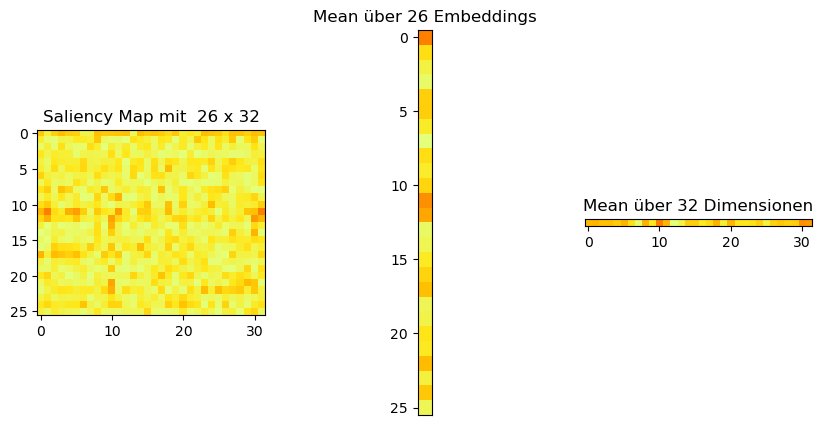

In [10]:
# def plot_saliency_map(all_saliency_maps, model, index=0):

current_mlp = vqvae_v1["mlp"]
current_model = vqvae_v1["model"]
sm = torch.tensor(my_saliency_map)
sm_summed_or_mean = sm.mean(dim=1, keepdim=True)
sm_dim_summed_or_mean = sm.mean(dim=0, keepdim=True)

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(sm, cmap='Wistia')
plt.title(f'Saliency Map mit  {current_model.enc_out_len} x {current_model.embedding_dim}')

plt.subplot(1, 3, 2)
plt.xticks([])
plt.imshow(sm_summed_or_mean, cmap='Wistia')
plt.title(f'Mean über {current_model.enc_out_len} Embeddings')

plt.subplot(1, 3, 3)
plt.yticks([])
plt.imshow(sm_dim_summed_or_mean, cmap='Wistia')
plt.title(f'Mean über {current_model.embedding_dim} Dimensionen')

plt.show()

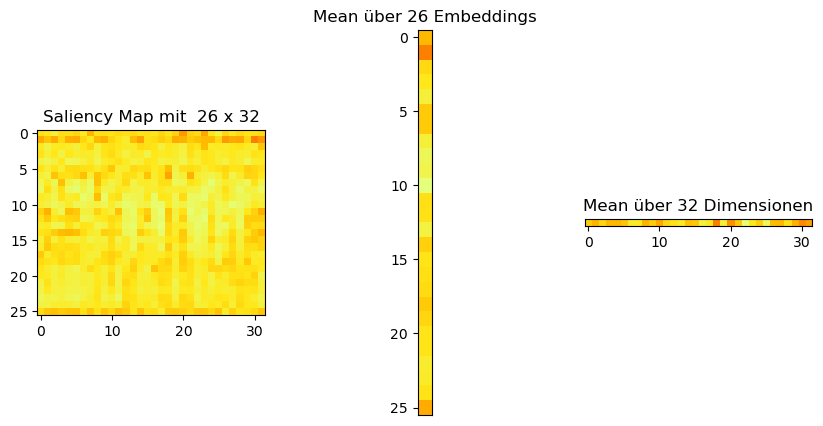

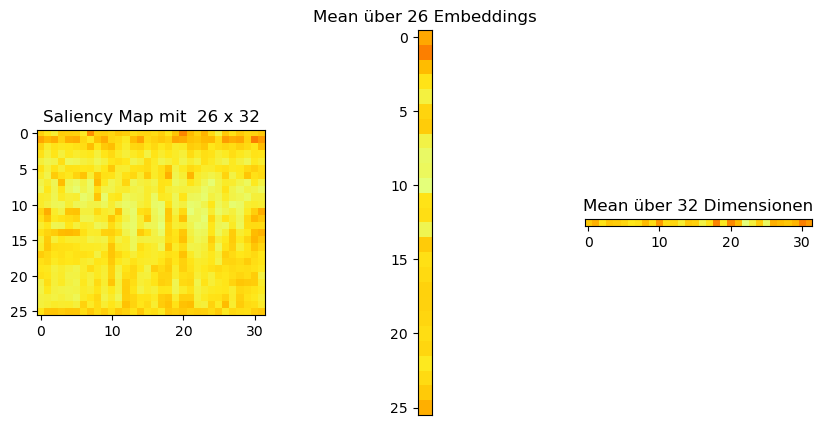

In [15]:
def create_mean_saliency_map(all_saliency_maps):
    mean_saliency_map = all_saliency_maps.mean(axis=0)
    return mean_saliency_map

mean_sm = create_mean_saliency_map(all_saliency_maps)
mean_sm_bad = create_mean_saliency_map(all_saliency_maps_bad)
plot_saliency_map([mean_sm], index=0, model=current_model)
plot_saliency_map([mean_sm_bad], index=0, model=current_model)